# 服装描述生成结题报告

   小组成员：王拓、王维晨、任波

## 一、任务说明

### 1.任务背景

服装描述生成系统是一个旨在利用计算机视觉和自然语言处理技术，通过分析图像或其他形式的输入数据，生成对服装或时尚物品的文字描述，为用户提供基于图像的服装描述的项目。该系统旨在提供一种智能化的方式，使用户能够通过上传服装图片或描述来获取详细的文字描述，包括服装外观、款式、颜色、材质、纹理等信息。

服装描述生成通常涉及以下步骤，我们在本次项目中着重实现了前两项：

- 图像特征提取：使用计算机视觉技术，对输入的服装图像进行预处理和特征工程的步骤，提取相关的视觉特征，将其转换为计算机能够理解和处理的向量表示形式。

- 序列生成模型：使用自然语言处理技术和序列生成模型，如循环神经网络（RNN）或变换器（Transformer），将提取的图像特征作为输入，生成对服装的文字描述。这些模型可以学习上下文关系、语法规则和语义信息，以生成准确和连贯的描述。

- 文本后处理：生成的文字描述可能需要进行后处理，如语法修正、风格调整或语义调整，以确保生成的描述符合语言的规范和语义的准确性。

### 2.任务实现

#### 完成以下模型的搭建和训练

- **视觉 Transformer(Vit) + Transformer 解码器**
    - 手动搭建(Vit) + Transformer 解码器 进行训练
    - 采用预训练`vit_B_16`默认权重 + Transformer解码器
    - 两者对比效果
- **网格/区域表示、图网络+ Transformer解码器**
- **网格/区域表示、Transformer编码器+Transformer解码器**
- CNN + Transformer解码器 作为baseline


#### 新实现测评标准

- METEOR
- ROUGE-L
- CIDEr-D

#### 尝试完成了部分选做内容

- 微调多模态预训练大模型，并测试性能

### 3.任务分工

略

## 二、实验数据

### 2.1.基础数据集

我们使用的数据集为deepfashion-multimodal：
- 数据集包括12694张图片；
- 每张图片对应5个不同句子描述；
- 所有句子中出现的总词汇数为120。


### 2.2.创建数据集
采用的还是老师提供的处理逻辑，传入数据集，每张数据集的标注数和最大长度；返回字典和训练、验证、测试集的json文件。
具体细节：
- 注意把五个不同标注的句子当成一句话处理。在这里我们要改正一下中期我们犯下的错误，因为每句话描述的只是图片的一部分特征，我们最终把它当成五个标注训练最后预测是由问题的。
- 实现了训练集和验证集的9：1的划分。(不是8：2的原因是evalue的束搜索生成的太慢了，后来调试时间不够)
- 使用正则表达式分开逗号句号 `words = re.findall(r"[\w'-]+|[.,!?;]", sentences)`
- 增加 `<pad>，<unk>,<start>,<end>`,合法性检验,划分词典

In [1]:
%matplotlib inline
import os
import json
import random 
from collections import defaultdict, Counter
import re
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
def create_dataset(dataset='deepfashion',
                   captions_per_image=1, 
                   min_word_count=3, 
                   max_len=100):
    """
    参数：
        dataset：数据集名称
        captions_per_image：每张图片对应的文本描述数
        min_word_count：仅考虑在数据集中（除测试集外）出现5次的词
        max_len：文本描述包含的最大单词数，如果文本描述超过该值，则截断
    输出：
        一个词典文件： vocab.json
        三个数据集文件： train_data.json、 val_data.json、 test_data.json
    """

    karpathy_json_path='../data/%s/train_captions.json' % dataset  # 训练集的json文件
    image_folder='../data/%s/images' % dataset  # 图片folder
    output_folder='../data/%s/' % dataset  # 输出文件夹

    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)  # data是获取的json文件,data是一个字典！！！！！！！！
    
    image_paths = defaultdict(list)  # 图片路径
    image_captions = defaultdict(list)  # 图片标注
    vocab = Counter()  # 每个词语出现的次数

    # 假设data是你的数据集字典
    train_keys, val_keys = train_test_split(list(data.keys()), test_size=0.1, random_state=42)
    # i=0
    for img in data.keys():
        captions = []
        sentences = data[f'{img}']  # 1个句子
        words = re.findall(r"[\w'-]+|[.,!?;]", sentences)  # 将文本分割成单词和标点符号
        vocab.update(words)
        if len(words) <= max_len:
            captions.append(words)
        path = os.path.join(image_folder, img)

        if img in train_keys:
            image_paths['train'].append(path)
            image_captions['train'].append(captions)
        else:
            image_paths['val'].append(path)
            image_captions['val'].append(captions)
    karpathy_json_path_t='../data/%s/test_captions.json' % dataset  # 训练集的json文件
    with open(karpathy_json_path_t, 'r') as j:
        data = json.load(j)  # data是获取的json文件,data是一个字典！！！！！！！！
    for img in data.keys():
        captions = []
        sentences = data[f'{img}']  # 5个句子
        words = re.findall(r"[\w'-]+|[.,!?;]", sentences)
        if len(words) <= max_len:
                captions.append(words)
        path = os.path.join(image_folder, img)
        
        image_paths['test'].append(path)
        image_captions['test'].append(captions)
        
    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

# 储存词典
    try:
        with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
            json.dump(vocab, fw)
        print("Writing to 'vocab.json' successful!")
    except Exception as e:
        print("An error occurred while writing to 'vocab.json':", e)

    # 整理数据集
    for split in image_paths:
        # print(split)
        imgpaths = image_paths[split]  # 图片加载
        imcaps = image_captions[split]
        enc_captions = []

        for i, path in enumerate(imgpaths):
            # 合法性检查，检查图像是否可以被解析
            img = Image.open(path) 
            # 如果该图片对应的描述数量不足，则补足
            if len(imcaps[i]) < captions_per_image:
                captions = imcaps[i] + [''] * (captions_per_image - len(imcaps[i]))
                print('1')
            # 如果该图片对应的描述数量超了，则随机采样
            else:
                captions = random.sample(imcaps[i], k=captions_per_image)
            assert len(captions) == captions_per_image
            
            for j, c in enumerate(captions):
                # 对文本描述进行编码
                enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']] 
                enc_captions.append(enc_c)
        # 合法性检查
        assert len(imgpaths) * captions_per_image == len(enc_captions)
        
        # 存储数据
        data = {'IMAGES': imgpaths, 
                'CAPTIONS': enc_captions}
        with open(os.path.join(output_folder, split + '_data.json'), 'w') as fw:
            json.dump(data, fw)
# create_dataset()

### 2.3.选择图片进行输出测试
查看对应的标注

{'The': 1, 'upper': 2, 'clothing': 3, 'has': 4, 'long': 5, 'sleeves': 6, ',': 7, 'cotton': 8, 'fabric': 9, 'and': 10, 'solid': 11, 'color': 12, 'patterns': 13, '.': 14, 'neckline': 15, 'of': 16, 'it': 17, 'is': 18, 'v-shape': 19, 'lower': 20, 'length': 21, 'denim': 22, 'This': 23, 'lady': 24, 'also': 25, 'wears': 26, 'an': 27, 'outer': 28, 'with': 29, 'complicated': 30, 'female': 31, 'wearing': 32, 'a': 33, 'ring': 34, 'on': 35, 'her': 36, 'finger': 37, 'neckwear': 38, 'Her': 39, 'tank': 40, 'shirt': 41, 'no': 42, 'chiffon': 43, 'graphic': 44, 'It': 45, 'round': 46, 'person': 47, 'pants': 48, 'are': 49, 'top': 50, 'woman': 51, 'trousers': 52, 'There': 53, 'belt': 54, 'accessory': 55, 'wrist': 56, 'sweater': 57, 'lattice': 58, 'the': 59, 'three-point': 60, 'pure': 61, 'in': 62, 'his': 63, 'neck': 64, 'long-sleeve': 65, 'plaid': 66, 'its': 67, 'lapel': 68, 'socks': 69, 'shoes': 70, 'suspenders': 71, 'short-sleeve': 72, 'T-shirt': 73, 'shorts': 74, 'crew': 75, 'short': 76, 'sleeveless': 7

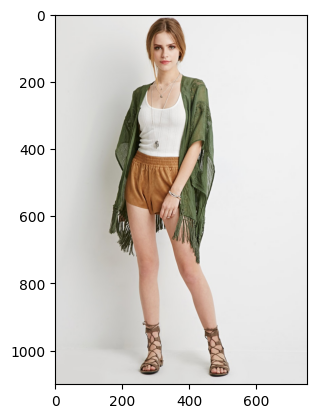

In [2]:
# 读取词典和验证集
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
    print(vocab)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open('../data/deepfashion/val_data.json', 'r') as f:
    data = json.load(f)

# 展示第12张图片，其对应的文本描述序号是60到64
print(data['IMAGES'][10])
content_img = Image.open(data['IMAGES'][10])
plt.imshow(content_img)

print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][10]]))
print(content_img.size)

### 2.4.实现预测的数字生成句子函数

In [3]:
import json
def generated_sentences(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
        print(vocab)
    vocab_idx2word = {idx:word for word,idx in vocab.items()}
    for i, text in enumerate(data):
        print(' '.join([vocab_idx2word[word_idx] for word_idx in text]))


In [7]:
data = [[112, 39, 57, 4, 5, 6, 7, 8, 9, 10, 61, 12, 13, 14, 45, 4, 33, 19, 15, 14, 1, 48, 80, 51, 26, 18, 16, 5, 21, 14, 1, 48, 49, 29, 8, 9, 10, 11, 12, 13, 14, 1, 28, 3, 18, 29, 8, 9, 10, 30, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 47, 18, 32, 33, 101, 41, 29, 96, 13, 14, 1, 41, 18, 29, 8, 9, 14, 45, 4, 33, 71, 15, 14, 1, 48, 59, 47, 26, 18, 16, 5, 21, 14, 1, 48, 49, 29, 22, 9, 10, 11, 12, 13, 14, 23, 51, 26, 33, 34, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 113], [112, 39, 41, 4, 76, 6, 7, 43, 9, 10, 61, 12, 13, 14, 1, 15, 16, 17, 18, 68, 14, 1, 74, 80, 24, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 22, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 1, 31, 26, 33, 34, 14, 113], [112, 23, 31, 26, 33, 40, 40, 50, 29, 44, 13, 10, 33, 60, 48, 14, 1, 40, 50, 18, 29, 8, 9, 10, 67, 15, 18, 46, 14, 1, 48, 49, 29, 8, 9, 10, 11, 12, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 39, 40, 41, 4, 42, 6, 7, 43, 9, 10, 44, 13, 14, 45, 4, 33, 71, 15, 14, 23, 51, 26, 33, 60, 74, 14, 1, 74, 49, 29, 22, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 23, 24, 26, 33, 40, 40, 50, 29, 11, 12, 13, 10, 33, 5, 52, 14, 1, 40, 50, 18, 29, 8, 9, 14, 1, 15, 16, 59, 40, 50, 18, 71, 14, 1, 52, 49, 29, 8, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 1, 2, 3, 4, 5, 6, 7, 90, 9, 10, 61, 12, 13, 14, 1, 15, 16, 17, 18, 46, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 22, 10, 17, 4, 11, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 23, 51, 18, 32, 33, 34, 35, 36, 37, 14, 113], [112, 23, 24, 18, 32, 33, 65, 57, 29, 61, 12, 13, 14, 1, 57, 18, 29, 8, 9, 10, 67, 15, 18, 46, 14, 1, 52, 80, 24, 26, 18, 16, 5, 21, 14, 1, 52, 49, 29, 8, 9, 10, 11, 12, 13, 14, 1, 28, 3, 18, 29, 8, 9, 10, 11, 12, 13, 14, 23, 24, 26, 33, 34, 14, 113], [112, 1, 31, 26, 33, 77, 40, 41, 29, 61, 12, 13, 14, 1, 40, 41, 18, 29, 43, 9, 14, 1, 31, 26, 33, 5, 48, 14, 1, 48, 49, 29, 43, 9, 10, 11, 12, 13, 14, 23, 24, 26, 33, 34, 14, 113], [112, 23, 24, 18, 32, 33, 65, 57, 29, 11, 12, 13, 10, 33, 60, 48, 14, 1, 57, 18, 29, 8, 9, 10, 67, 15, 18, 46, 14, 1, 48, 49, 29, 8, 9, 10, 11, 12, 13, 14, 1, 28, 3, 80, 24, 26, 18, 29, 8, 9, 10, 11, 12, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 23, 24, 18, 32, 33, 101, 41, 29, 61, 12, 13, 14, 1, 41, 18, 29, 8, 9, 10, 67, 15, 18, 71, 14, 1, 74, 80, 24, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 8, 9, 10, 61, 12, 13, 14, 23, 24, 25, 26, 27, 28, 3, 7, 29, 8, 9, 10, 44, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 113], [112, 23, 24, 26, 33, 77, 40, 50, 29, 11, 12, 13, 10, 33, 5, 52, 14, 1, 40, 50, 18, 29, 8, 9, 14, 1, 15, 16, 59, 40, 50, 18, 71, 14, 1, 52, 49, 29, 8, 9, 10, 66, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 39, 41, 4, 76, 6, 7, 8, 9, 10, 44, 13, 14, 1, 15, 16, 17, 18, 46, 14, 1, 24, 26, 33, 5, 48, 14, 1, 48, 49, 29, 22, 9, 10, 11, 12, 13, 14, 23, 51, 26, 33, 81, 16, 97, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 23, 91, 18, 32, 33, 72, 41, 29, 11, 12, 13, 14, 1, 41, 18, 29, 8, 9, 14, 45, 4, 33, 46, 15, 14, 1, 48, 80, 91, 26, 18, 16, 5, 21, 14, 1, 48, 49, 29, 8, 9, 10, 11, 12, 13, 14, 113], [112, 1, 47, 26, 33, 101, 41, 29, 11, 12, 13, 14, 1, 41, 18, 29, 8, 9, 14, 1, 48, 59, 47, 26, 18, 16, 60, 21, 14, 1, 48, 49, 29, 22, 9, 10, 11, 12, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 1, 31, 18, 32, 33, 72, 41, 29, 11, 12, 13, 14, 1, 41, 18, 29, 8, 9, 10, 67, 15, 18, 46, 14, 1, 52, 59, 31, 26, 18, 16, 5, 21, 14, 1, 52, 49, 29, 22, 9, 10, 11, 12, 13, 14, 1, 28, 3, 18, 29, 90, 9, 10, 44, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 23, 31, 18, 32, 33, 72, 41, 29, 44, 13, 10, 33, 5, 52, 14, 1, 41, 18, 29, 8, 9, 14, 1, 15, 16, 59, 41, 18, 46, 14, 1, 52, 49, 29, 22, 9, 10, 11, 12, 13, 14, 113], [112, 1, 57, 80, 47, 26, 4, 5, 6, 10, 17, 18, 29, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 59, 57, 18, 46, 14, 23, 47, 26, 33, 60, 48, 7, 29, 8, 9, 10, 44, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 39, 40, 50, 4, 6, 87, 88, 7, 8, 9, 10, 44, 13, 14, 45, 4, 33, 71, 15, 14, 1, 31, 26, 33, 5, 48, 14, 1, 48, 49, 29, 8, 9, 10, 44, 13, 14, 23, 51, 26, 33, 79, 14, 23, 51, 26, 33, 34, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 113], [112, 23, 51, 18, 32, 33, 72, 73, 29, 11, 12, 13, 10, 33, 5, 48, 14, 1, 73, 18, 29, 8, 9, 14, 1, 15, 16, 59, 73, 18, 46, 14, 1, 48, 49, 29, 22, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 40, 50, 80, 47, 26, 4, 42, 6, 10, 17, 18, 29, 8, 9, 10, 44, 13, 14, 1, 15, 16, 59, 40, 50, 18, 46, 14, 23, 47, 26, 33, 60, 74, 7, 29, 8, 9, 10, 44, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 23, 31, 18, 32, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 113], [112, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 13, 14, 1, 15, 16, 17, 18, 46, 14, 1, 20, 3, 18, 16, 60, 21, 14, 1, 9, 18, 8, 10, 17, 4, 44, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 75, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 22, 10, 17, 4, 61, 12, 13, 14, 23, 51, 18, 32, 33, 34, 35, 36, 37, 14, 53, 18, 33, 79, 62, 36, 83, 14, 113], [112, 1, 2, 3, 4, 5, 6, 7, 43, 9, 10, 44, 13, 14, 1, 15, 16, 17, 18, 71, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 22, 10, 17, 4, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 31, 18, 32, 33, 72, 41, 29, 44, 13, 14, 1, 41, 18, 29, 8, 9, 10, 67, 15, 18, 46, 14, 1, 74, 59, 31, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 22, 9, 10, 78, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 23, 51, 26, 103, 14, 113], [112, 1, 47, 18, 32, 33, 72, 41, 29, 44, 13, 14, 1, 41, 18, 29, 8, 9, 14, 45, 4, 33, 19, 15, 14, 1, 74, 59, 24, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 22, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 23, 31, 26, 33, 77, 40, 41, 29, 11, 12, 13, 14, 1, 40, 41, 18, 29, 8, 9, 14, 45, 4, 33, 46, 15, 14, 1, 74, 80, 31, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 8, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 23, 31, 26, 33, 72, 73, 29, 11, 12, 13, 14, 1, 73, 18, 29, 8, 9, 14, 45, 4, 33, 46, 15, 14, 23, 31, 26, 33, 5, 48, 14, 1, 48, 49, 29, 8, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 40, 41, 80, 51, 26, 4, 6, 87, 88, 10, 17, 18, 29, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 59, 40, 41, 18, 71, 14, 23, 31, 26, 33, 60, 74, 7, 29, 8, 9, 10, 44, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 39, 41, 4, 5, 6, 7, 90, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 99, 14, 1, 47, 26, 33, 5, 52, 14, 1, 52, 49, 29, 22, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 53, 18, 3, 35, 36, 84, 14, 1, 31, 18, 32, 33, 34, 35, 36, 37, 14, 113], [112, 1, 2, 3, 4, 89, 6, 7, 8, 9, 10, 94, 13, 14, 45, 4, 33, 46, 15, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 8, 10, 17, 4, 11, 12, 13, 14, 113], [112, 23, 51, 26, 33, 65, 41, 29, 44, 13, 10, 33, 5, 52, 14, 1, 41, 18, 29, 8, 9, 14, 1, 15, 16, 59, 41, 18, 46, 14, 1, 52, 49, 29, 8, 9, 10, 11, 12, 13, 14, 1, 28, 3, 18, 29, 8, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113]]
generated_sentences(data)

{'The': 1, 'upper': 2, 'clothing': 3, 'has': 4, 'long': 5, 'sleeves': 6, ',': 7, 'cotton': 8, 'fabric': 9, 'and': 10, 'solid': 11, 'color': 12, 'patterns': 13, '.': 14, 'neckline': 15, 'of': 16, 'it': 17, 'is': 18, 'v-shape': 19, 'lower': 20, 'length': 21, 'denim': 22, 'This': 23, 'lady': 24, 'also': 25, 'wears': 26, 'an': 27, 'outer': 28, 'with': 29, 'complicated': 30, 'female': 31, 'wearing': 32, 'a': 33, 'ring': 34, 'on': 35, 'her': 36, 'finger': 37, 'neckwear': 38, 'Her': 39, 'tank': 40, 'shirt': 41, 'no': 42, 'chiffon': 43, 'graphic': 44, 'It': 45, 'round': 46, 'person': 47, 'pants': 48, 'are': 49, 'top': 50, 'woman': 51, 'trousers': 52, 'There': 53, 'belt': 54, 'accessory': 55, 'wrist': 56, 'sweater': 57, 'lattice': 58, 'the': 59, 'three-point': 60, 'pure': 61, 'in': 62, 'his': 63, 'neck': 64, 'long-sleeve': 65, 'plaid': 66, 'its': 67, 'lapel': 68, 'socks': 69, 'shoes': 70, 'suspenders': 71, 'short-sleeve': 72, 'T-shirt': 73, 'shorts': 74, 'crew': 75, 'short': 76, 'sleeveless': 7

### 2.5.实现自定义的 PyTorch 数据类 ImageTextDataset
这段代码用于处理图像和对应的文本描述数据。用于 PyTorch DataLoader 以批次方式产生数据的一个工具。

- __init__ 接收一些参数，包括数据集路径 dataset_path、词典路径 vocab_path、数据集的划分（训练集、验证集、测试集）、每张图片的文本描述数、每个文本描述的最大单词数以及图像预处理方法。
- __getitem__ 方法根据给定的索引 i 返回一个数据对，包括图像和对应的文本描述。它通过索引找到图像，并将其转换为 PyTorch 的张量。对于文本描述，它创建了一个长为 self.max_len + 2 的长整型张量，其中文本被填充到了最大长度，并使用了 pad 标记。
- __len__ 方法返回整个数据集的大小。

这个类的主要作用是在 PyTorch 中加载图像和对应的文本描述数据集，并使其可以被 DataLoader 以批次的方式调用。

In [4]:
from argparse import Namespace 
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageTextDataset(Dataset):
    """
    PyTorch数据类，用于PyTorch DataLoader来按批次产生数据
    """

    def __init__(self, dataset_path, vocab_path, split, captions_per_image=1, max_len=100, transform=None):
        """
        参数：
            dataset_path：json格式数据文件路径
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.split = split
        assert self.split in {'train', 'val', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # 载入数据集
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # PyTorch图像预处理流程
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i // self.cpi]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))
        
        return img, caption, caplen
        

    def __len__(self):
        return self.dataset_size

### 2.6 创建训练集、验证集和测试集
- 定义了训练集 train_tx 和验证集 val_tx 的图像预处理方法，分别包括了图像的 Resize、Crop、转换为张量、以及归一化处理。
    - 重要的参数是`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]`要符合预训练模型的说明
    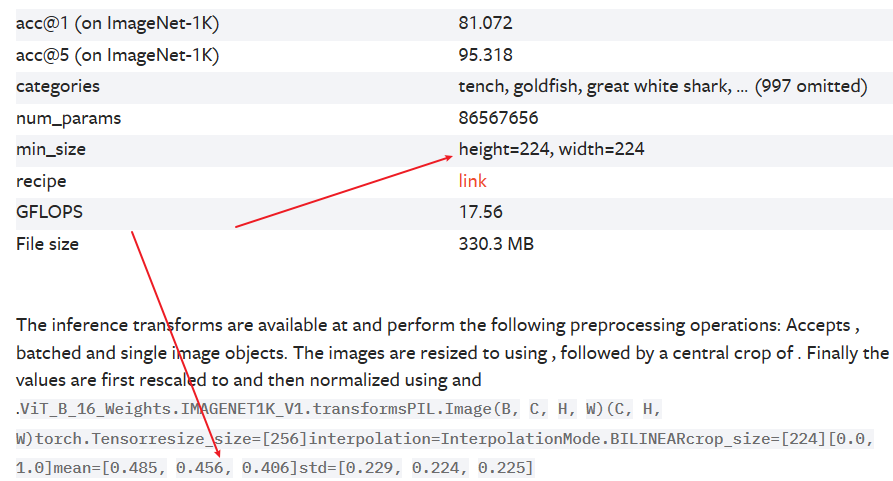
- 通过 ImageTextDataset 类，它将训练、验证和测试数据集加载到内存中，每个数据集使用相应的预处理方法。
- 利用 PyTorch 的 DataLoader 分别创建了训练集、验证集和测试集的 DataLoader，设置了批次大小、是否打乱数据、以及多线程加载数据的参数。

In [5]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    """
    data_dir: 数据集文件夹
    vocab_path: 词典文件路径
    batch_size: 批次大小
    workers: 多线程加载数据的线程数
    """
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = ImageTextDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = ImageTextDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = ImageTextDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    

## 三、定义模型
这里的模型是**vit+Transformer解码器**。
编码器方面：
- 使用了自己搭建的Vit和预训练Vit分别训练，进行对比。
- 同时代码里还留存这ResNet-10特征提取。
- **解码器**: 使用TransformerDecoderLayer加上embedded和位置编码等实现Transformer解码器

### 3.1图像编码器


#### 3.1.1 CNN特征提取

这里主要的操作就是直接使用ResNet-101的特征提取网络和进行的维度变化，以便更好地和解码器做多头注意力。
- 在 __init__ 方法中，首先加载了预训练好的 ResNet-101 模型，并设置了 grid_rep_extractor 用于提取图像特征。通常，ResNet 的最后几层是全局平均池化层和全连接层，这里取掉了这部分，保留了特征提取器。
- 参数 finetuned 控制是否将 grid_rep_extractor 中的参数设置为可训练的。如果 finetuned 为 True，则这些参数是可训练的；如果为 False，则这些参数不会被更新，保持预训练时的权重。
- `self.fc = nn.Linear(2048, 512)`更好地和解码器做多头注意力
- 在 forward 方法中，输入的图像经过 grid_rep_extractor 处理后得到特征张量 out，其形状是 (batch_size, channels, height * width)。
- 最后在调整通道的维度，把特征维度放到第2维

In [6]:
# CNN特征提取器
from torchvision.models import ResNet101_Weights
import torch.nn.functional as F

class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True):
        super(ImageEncoder, self).__init__()
        model = torchvision.models.resnet101(weights=ResNet101_Weights.DEFAULT)
        # ResNet-101网格表示提取器
        self.grid_rep_extractor = nn.Sequential(*(list(model.children())[:-2]))
        for param in self.grid_rep_extractor.parameters():
            param.requires_grad = finetuned
        self.fc = nn.Linear(2048, 512)
    def forward(self, images):
        out = self.grid_rep_extractor(images)   # 提取的是图片特征一堆数字

        # 获取张量的形状
        batch_size, channels, height, width = out.size()

        # 将第三和第四维合并成一个新的维度
        out = out.view(batch_size, channels, height * width)
        out = out.permute(0, 2, 1)  # 交换第二维和第三维
        out = self.fc(out)
        return out


#### 3.1.2 预训练的vit_b_16作为编码器
首先对输入数据进行预处理，然后扩展一个批次的类别令牌。接下来，使用 Vision Transformer 的编码器部分处理输入数据，最终返回编码后的特征表示。

In [7]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

class VitEncoder(nn.Module):
    def __init__(self,finetuned=True):
        super().__init__()
        self.vit = vit_b_16(weights="IMAGENET1K_V1", progress=True)

        if  finetuned:
            for param in self.vit.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.vit._process_input(x)
        
        n = x.shape[0]
        batch_class_token = self.vit.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        
        x = self.vit.encoder(x)
        return x


In [8]:
model = VitEncoder()
print(model)


VitEncoder(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate=none)
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNor

In [9]:
v = VitEncoder()
img = torch.randn(1, 3, 224, 224)
preds = v(img) # (1, 1000)
print(preds.shape)

torch.Size([1, 197, 768])


#### 3.1.3 自己搭建的Vit

Transformer编码器
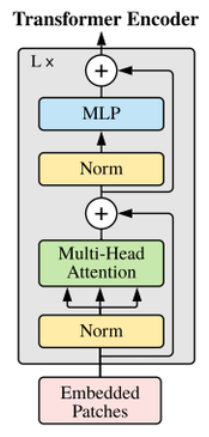
- 在每一层中，输入 x 首先经过自注意力机制层（Attention），然后通过残差连接（residual connection）与输入相加。接着，将得到的结果输入到前馈神经网络层（FeedForward）中，同样进行残差连接并相加。这个过程重复了多次（由 depth 参数控制），最终通过层归一化（Layer Normalization）返回输出。


In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

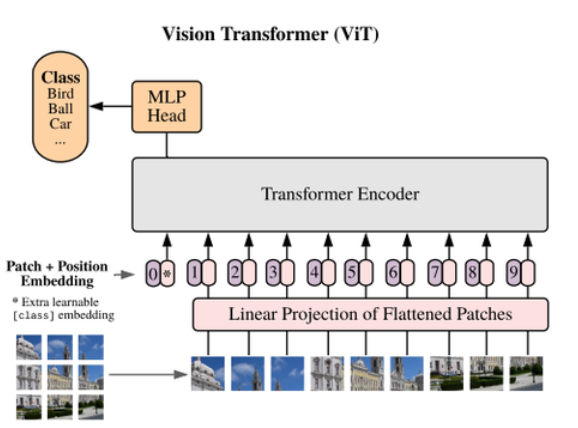
-  patch embedding：例如输入图片大小为224x224，将图片分为固定大小的patch，patch大小为16x16，则每张图像会生成224x224/16x16=196个patch，即输入序列长度为196，每个patch维度16x16x3=768，线性投射层的维度为768xN (N=768)，因此输入通过线性投射层之后的维度依然为196x768，即一共有196个token，每个token的维度是768。这里还需要加上一个特殊字符cls，因此最终的维度是197x768。到目前为止，已经通过patch embedding将一个视觉问题转化为了一个seq2seq问题
- positional encoding（standard learnable 1D position embeddings）：ViT同样需要加入位置编码，位置编码可以理解为一张表，表一共有N行，N的大小和输入序列长度相同，每一行代表一个向量，向量的维度和输入序列embedding的维度相同（768）。注意位置编码的操作是sum，而不是concat。加入位置编码信息之后，维度依然是197x768
- 多头注意力：LN输出维度依然是197x768。多头自注意力时，先将输入映射到q，k，v，如果只有一个头，qkv的维度都是197x768，如果有12个头（768/12=64），则qkv的维度是197x64，一共有12组qkv，最后再将12组qkv的输出拼接起来，输出维度是197x768，然后在过一层LN，维度依然是197x768

In [11]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        """
        image_size: 图片大小
        patch_size: 分块大小
        num_classes: 分类数
        dim: 每个分块的维度
        depth: 深度
        heads: 多头注意力的头数
        mlp_dim: MLP的维度
        pool: 池化方式
        channels: 通道数
        dim_head: 头的维度
        dropout: dropout率
        emb_dropout: 嵌入层的dropout率
        """
        super().__init__()

        # 返回一个元组，图片大小分块大小
        image_height, image_width = pair(image_size)  # 图片大小 224*224
        patch_height, patch_width = pair(patch_size)  # 分块大小 16*16

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'  # 判断必须可分

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # 计算个数
        patch_dim = channels * patch_height * patch_width  # 每一块多少维 3*16*16
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),  # 图分割 N 14*14 16*16*3
            nn.LayerNorm(patch_dim),  # 层正则化
            nn.Linear(patch_dim, dim), # 映射 16*16*3 到 
            nn.LayerNorm(dim),  # 层正则化
        )  # 分块

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        # self.to_512 = nn.Linear(num_patches + 1, 512)
    def forward(self, img):
        x = self.to_patch_embedding(img)
        # print(x.shape)
        b, n, _ = x.shape  
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)
        return x

In [12]:
# 视觉Transformer作为图像编码器
v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 512,
    depth = 4,
    heads = 6,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
img = torch.randn(1, 3, 224, 224)
preds = v(img) # (1, 257, 1024)
print(preds.shape)

torch.Size([1, 197, 512])


### 3.2文本解码器

我们使用Transformer解码器。实现了输入序列的编码，加上位置编码。创建target的上三角掩码，接着把图片特征，序列编码，tgt_mask送到TransformerdecoderLayer，获取到输出。
- 在 __init__ 方法中，我们初始化解码器模型的结构。包括词嵌入层 self.embed、位置编码 self.pos_embedding、多层的 Transformer 解码器 self.decoder_layers、全连接层 self.fc 等组件。这些层的作用是将输入的序列进行解码，输出对应的标注序列。
- **init_weights** 方法用于初始化模型参数的权重。
- **forward_step** 方法用于执行解码器的单步前向传播，处理当前步骤的信息。其实这个就是为了配合GRU的单步预测写的forward_step,在束搜索中执行，用于预测下一个单词，本质上还是forward，只不过只取最后一个预测单词。
- **forward** 方法是模型的前向传播过程。它接收图像特征 image_features、标注序列 captions 和标注序列的长度 lengths。在前向传播过程中，首先将标注序列进行词嵌入和位置编码，然后经过 Transformer 解码器的多层处理，最终输出预测结果。
- 最后有一个返回对齐的操作`return predictions[:, :-1, :], captions[:, 1:], lengths - 1`,-1是因为那是<end>的后一个单词，没有意义。captions[:, 1:]是因为prediction没有预测第一个单词，lengths - 1是有效长度-1。
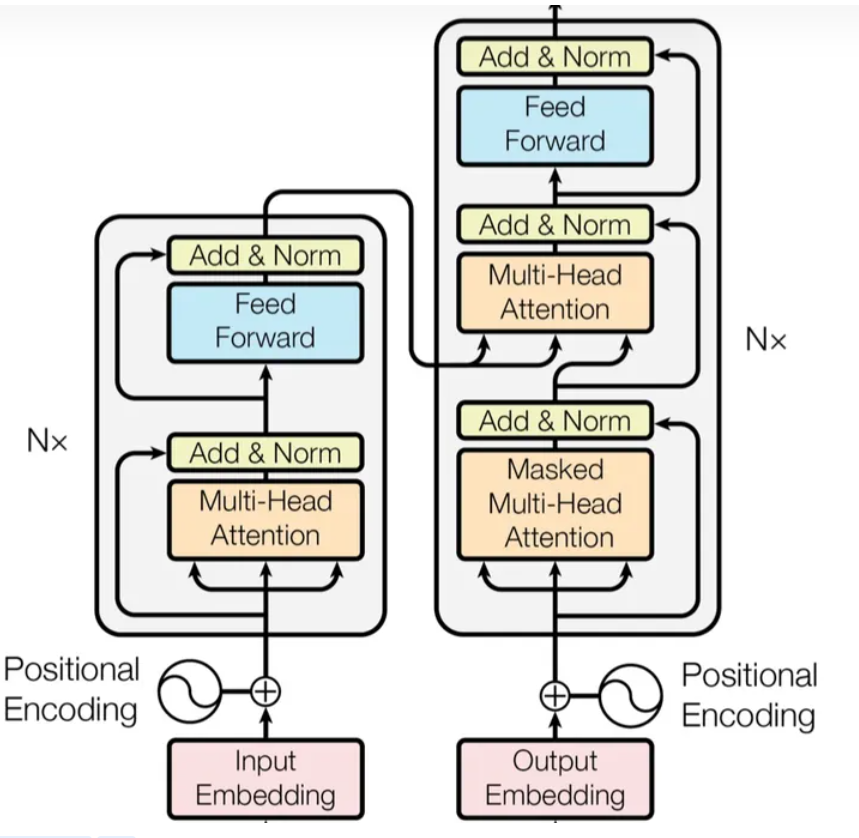

位置编码：

- 在 __init__ 方法中，创建了一个大小为 (max_len, d_model) 的零矩阵 pe 作为位置编码的容器。然后，对于每个位置，通过一定的数学计算，计算出了不同频率的正弦和余弦值，并将这些值赋给 pe 矩阵的奇数列和偶数列，以此构建位置编码矩阵。

- 在 forward 方法中，将位置编码矩阵 pe 添加到输入张量 x 的每个位置上。这个过程是通过将输入张量的大小与位置编码的大小相匹配，然后将位置编码加到输入张量上。这样，模型在处理输入时就能考虑到序列中每个位置的信息，因为位置编码会提供关于序列顺序的固定信息。
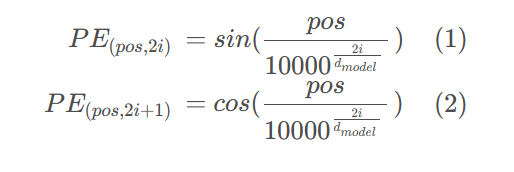

- pos表示token在序列中的位置，0-L-1,PE是位置向量.
- 一个词语的位置编码是由不同频率的余弦函数组成的，从低位到高位，余弦函数对应的频率由1降低到 1/10000

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term2 = torch.pow(torch.tensor(10000000.0), torch.arange(0, d_model, 2).float() / d_model)
        div_term1 = torch.pow(torch.tensor(10000000.0), torch.arange(1, d_model, 2).float() / d_model)
        pe[:, 0::2] = torch.sin(position * div_term2)
        pe[:, 1::2] = torch.cos(position * div_term1)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, word_dim, num_layers, num_heads, mlp_dim, dropout=0.1):
        """
        vocab_size: 词汇表大小
        word_dim: 词嵌入维度
        num_layers: 解码器层数
        num heads: 多头注意力的头数
        mlp_dim: MLP的维度
        dropout: dropout率
        """
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.pos_embedding = nn.Embedding(vocab_size, word_dim)  # positional embedding
        self.positional_encoding = PositionalEncoding(word_dim)
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=word_dim, nhead=num_heads, dim_feedforward=mlp_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(word_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_features, captions, lengths):
        batch_size, image_code_dim = image_features.size(0), image_features.size(2)
        # -> (batch_size, grid_height*grid_width+1, image_code_dim) 
        # （1）按照caption的长短排序
        sorted_cap_lens, sorted_cap_indices = torch.sort(lengths, 0, True)
        captions = captions[sorted_cap_indices]
        image_code = image_code[sorted_cap_indices]
        return image_code, captions, sorted_cap_lens, sorted_cap_indices
    
    def forward_step(self, image_features, captions_emb, lengths, step):
        """
        image_features: 图像特征 (batch_size, patch_num+1, dim)
        captions: 当前生成的部分标注序列 (batch_size, current_length)
        lengths: 标注序列的实际长度 (batch_size, )
        step: 当前解码的步骤
        """
        # 与 forward 方法类似，但只处理当前步骤的信息
        cap_embeds = captions_emb[:, :step]  # 使用传入的嵌入表示
        cap_embeds = self.positional_encoding(cap_embeds)

        mask = nn.Transformer.generate_square_subsequent_mask(cap_embeds.size(1)).to(cap_embeds.device)
        
        output = cap_embeds.transpose(0, 1)
        memory = image_features.transpose(0, 1)
        for i in range(len(self.decoder_layers)):
            output = self.decoder_layers[i](output, memory, mask)
        
        output = output[-1, :, :]
        output = self.fc(self.dropout(output))
        return output
    
    def forward(self, image_features, captions, lengths):
        
        # 同样是将图文数据按照文本的实际长度从长到短排序
        # image_features,captions,sorted_cap_lens, sorted_cap_indices = self.init_hidden_state(image_features, captions, lengths)
        # batch_size = image_features.size(0)
        # lengths = sorted_cap_lens.cpu().numpy() - 1
        # # 初始化变量：模型的预测结果和注意力分数
        # predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        # image_features: (batch_size, patch_num    ,dim)
        # captions: (batch_size, num_steps) 图片标注
        # lengths: (batch_size, ) 图片标注的长度
        cap_embeds = self.embed(captions) # (batch_size, num_steps, word_dim) num_steps是caption的长度,就是有多少单词,编码
        # print(cap_embeds)
        cap_embeds = self.positional_encoding(cap_embeds)
        # print(f'cap_embeds{cap_embeds.shape}')
        # for step in range(lengths[0]):
            
        mask = nn.Transformer.generate_square_subsequent_mask(cap_embeds.size(1)).to(captions.device)  # 对角掩码
        # print(f'mask{mask}')
        output = cap_embeds.transpose(0,1)
        memory = image_features.transpose(0,1)
        for layer in self.decoder_layers:
            # print(f'output{output.shape}')
            # print(f'mask{mask.shape}')
            # print(f'memory{memory.shape}')
            output = layer(output, memory, mask)  # Use image_features as memory
        output = output.transpose(0, 1)
        softmax_predictions = torch.softmax(output, dim=-1)
        _, predicted_indices = torch.max(softmax_predictions, dim=-1)
        # print(predicted_indices)
        predictions = self.fc(self.dropout(output))  # [1,5,123] 5个预测，每个123个维度
        # print(f'predictions{predictions.shape}')
        return predictions[:, :-1, :], captions[:, 1:], lengths - 1  # 不要最后一个

# Create a TransformerDecoder instance
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
decoder = TransformerDecoder(vocab_size=len(vocab), word_dim=512,  num_layers=1, num_heads=8,mlp_dim=2048, dropout=0.0)

v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

# 测试
img = torch.randn(2, 3, 224, 224)  
image_features = v(img)
print(f'image_features{image_features.shape}')
captions = torch.tensor([[1,2,3,4,5,6,7,8,9],[9,8,7,6,5,4,3,2,1]])# Assume there are two samples, each with 5 words
print(captions.shape)
lengths = torch.tensor([9,8])  # Actual lengths of each sample is 5

# Perform forward propagation
predictions, targets, lengths = decoder(image_features, captions, lengths)
softmax_predictions = torch.softmax(predictions, dim=-1)
_, predicted_indices = torch.max(softmax_predictions, dim=-1)
predicted_indices_list = predicted_indices.tolist()
print(predicted_indices_list)
generated_sentences(predicted_indices_list)
# Print the results
print("Predictions:")
print(predictions.shape)
print("Targets:")
print(targets)
print("Lengths:")
print(lengths)


image_featurestorch.Size([2, 197, 512])
torch.Size([2, 9])
[[102, 102, 102, 102, 102, 102, 102, 102], [26, 26, 26, 26, 26, 26, 26, 26]]
{'The': 1, 'upper': 2, 'clothing': 3, 'has': 4, 'long': 5, 'sleeves': 6, ',': 7, 'cotton': 8, 'fabric': 9, 'and': 10, 'solid': 11, 'color': 12, 'patterns': 13, '.': 14, 'neckline': 15, 'of': 16, 'it': 17, 'is': 18, 'v-shape': 19, 'lower': 20, 'length': 21, 'denim': 22, 'This': 23, 'lady': 24, 'also': 25, 'wears': 26, 'an': 27, 'outer': 28, 'with': 29, 'complicated': 30, 'female': 31, 'wearing': 32, 'a': 33, 'ring': 34, 'on': 35, 'her': 36, 'finger': 37, 'neckwear': 38, 'Her': 39, 'tank': 40, 'shirt': 41, 'no': 42, 'chiffon': 43, 'graphic': 44, 'It': 45, 'round': 46, 'person': 47, 'pants': 48, 'are': 49, 'top': 50, 'woman': 51, 'trousers': 52, 'There': 53, 'belt': 54, 'accessory': 55, 'wrist': 56, 'sweater': 57, 'lattice': 58, 'the': 59, 'three-point': 60, 'pure': 61, 'in': 62, 'his': 63, 'neck': 64, 'long-sleeve': 65, 'plaid': 66, 'its': 67, 'lapel': 6

测试TransformerDecoder的代码

In [16]:
vocab_size = 5
decoder = TransformerDecoder(vocab_size=vocab_size, word_dim=512, num_layers=6, num_heads=8, mlp_dim=2048, dropout=0.1)

# 创建一个简单的模拟数据
batch_size = 2
max_seq_length = 3
word_dim = 512

image_features = torch.randn(batch_size, 10, word_dim)  # (batch_size, num_patches+1, word_dim)
captions = torch.randint(1, vocab_size, (batch_size, max_seq_length))  # (batch_size, max_seq_length)
lengths = torch.randint(2, max_seq_length, (batch_size,))  # (batch_size,)
print(captions.shape)
# 将captions嵌入
captions_emb = decoder.embed(captions)
print(image_features.shape,captions_emb.shape,lengths.shape)
# 进行前向传播
predictions = []
for i in range(max_seq_length - 1):  # 逐步预测每个词
    output = decoder.forward_step(image_features, captions_emb, lengths, i+1)  # 第i+1步的预测

    predictions.append(output.unsqueeze(1))  # 将每步的预测添加到列表中

predictions = torch.cat(predictions, dim=1)  # (batch_size, max_seq_length-1, vocab_size)
print("Predictions shape:", predictions)


torch.Size([2, 3])
torch.Size([2, 10, 512]) torch.Size([2, 3, 512]) torch.Size([2])
Predictions shape: tensor([[[-1.6470,  1.8174,  3.3138,  2.0851, -0.0830],
         [-1.5768,  0.4328,  1.9566,  0.5502, -1.7980]],

        [[-1.0692,  1.1409,  1.5552,  1.5502,  0.0558],
         [ 0.4137,  1.5292,  0.1872,  0.9474,  0.6769]]],
       grad_fn=<CatBackward0>)


### 3.3 图像描述模型模型

在定义编码器和解码器完成之后，我们就很容易构建图像描述模型了。仅需要在初始化函数时声明编码器和解码器，然后在前馈函数实现里，将编码器的输出和文本描述作为解码器的输入即可。这里我们额外定义了束搜索采样函数，用于生成句子，以计算BLEU值。下面的代码详细标注了其具体实现。

束搜索（Beam Search）来生成图像描述的文本。它接受图像作为输入，通过解码器（Transformer Decoder）生成对应的文本描述。
Transformer解码器在训练的时候，由于Target_mask的存在我们可以把整个captions序列输入进去，单个单词只他和他之前的单词做多头注意力。可以并行训练。
在预测的时候，我们需要单步预测，输入当前序列，我们只取预测出的下一个词，因此实现了类似的forward_step。

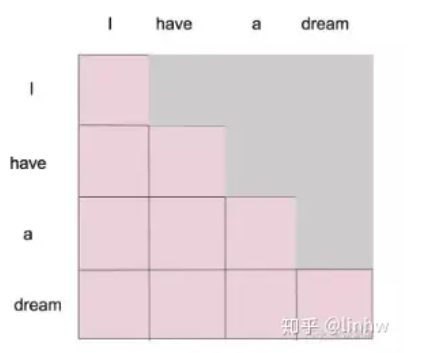

在这个方法中：

- 首先，通过编码器（Encoder）处理输入的图像，得到图像的特征表示 image_codes。
- 针对每张图像执行束搜索，对于每张图像，循环进行以下操作：
- 初始化开始标志 start 作为初始文本片段，并使用词嵌入得到当前文本片段的嵌入表示。
- 通过对输入的嵌入序列进行位置编码，生成掩码。
- 逐步预测下一个单词并扩展候选句子，利用预测的概率对新的候选句子进行排序。
- 根据束搜索策略，选择最有可能的 k 个句子作为下一步的候选句子。
- 如果生成的句子中出现结束符 end，则将其存储在 end_sents 中。
- 若全部生成的句子都包含了结束符 end，则停止生成过程。
- 最后，从生成的句子中选取概率最大的作为最终的文本描述，并将这些描述添加到 texts 列表中。

In [14]:
import torch
class VitTransformerDecoder(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, num_layers):
        super(VitTransformerDecoder, self).__init__()
        self.vocab = vocab
        self.encoder = VitEncoder()
        # self.encoder = ImageEncoder()
        # self.encoder = ViT(
        #     image_size = 224,
        #     patch_size = 16,
        #     num_classes = 1000,
        #     dim = word_dim,
        #     depth = 6,
        #     heads = 8,
        #     mlp_dim = 2048,
        #     dropout = 0.2,
        #     emb_dropout = 0.2
        # )
        self.decoder = TransformerDecoder(
            vocab_size=len(vocab),
            word_dim=word_dim,
            num_layers=num_layers,
            num_heads=4,
            mlp_dim=2048,
            dropout = 0.2,
        )

    def forward(self, image, captions, lengths):
        """
        image: (batch_size, 3, 224, 224)
        captions: (batch_size, num_steps) 图片标注
        lengths: (batch_size, ) 图片标注的长度
        """
        image_features = self.encoder(image)
        predictions, targets, lengths = self.decoder(image_features, captions, lengths)
        return predictions, targets, lengths
    
    def generate_by_beamsearch(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)  # 图片特征
        # print(f'image_codes{image_codes.shape}')  #([2, 512, 1024])
        texts = []
        device = images.device
        # 对每个图像样本执行束搜索
        for image_code in image_codes:  # 对于每张图片
            # 将图像表示复制k份
            image_code = image_code.unsqueeze(0).repeat(beam_k,1,1,1)
            # 生成k个候选句子，初始时，仅包含开始符号<start>
            cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device)  # 初始状态
            # print(f'cur_sents{cur_sents.shape}')
            cur_sent_embed = self.decoder.embed(cur_sents)  # embed编码
            sent_lens = torch.LongTensor([1]*beam_k).to(device)  # 当前长度只有1
            # 存储已生成完整的句子（以句子结束符<end>结尾的句子）
            end_sents = []
            # 存储已生成完整的句子的概率
            end_probs = []
            # 存储未完整生成的句子的概率
            probs = torch.zeros(beam_k, 1).to(device)
            k = beam_k
            step= 1
            while True:
                image_code = image_code.squeeze(1)
                # print(f'image_codes[k]{image_code[:k].shape}')
                # print(f'cur_sent_embed{cur_sent_embed.shape}')
                preds = self.decoder.forward_step(image_code[:k], cur_sent_embed,0,step=step)  # image_features, captions, lengths, i+1
                # print(f'print{preds.shape}') # 只预测一个词[5, 123]
                step+=1
                # -> (k, vocab_size)
                preds = nn.functional.log_softmax(preds, dim=1)  # 转化成概率分布
                
                # 对每个候选句子采样概率值最大的前k个单词生成k个新的候选句子，并计算概率
                # -> (k, vocab_size)
                probs = probs.repeat(1,preds.size(1)) + preds
                # print(f'prob{probs.shape}')
                non_end_indices = [i for i in range(len(self.vocab)) if i != self.vocab['<end>']]
                if cur_sents.size(1) == 1:  # 这一步容易出end
                    # 第一步时，所有句子都只包含开始标识符，因此，仅利用其中一个句子计算topk
                    values, indices = probs[0][non_end_indices].topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices}')
                else:
                    # probs: (k, vocab_size) 是二维张量
                    # topk函数直接应用于二维张量会按照指定维度取最大值，这里需要在全局取最大值
                    # 因此，将probs转换为一维张量，再使用topk函数获取最大的k个值
                    values, indices = probs.view(-1).topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices.shape}')
                # 计算最大的k个值对应的句子索引和词索引
                sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc') 
                # print(f'sent_indices{sent_indices.shape}')
                word_indices = indices % vocab_size 
                # 将词拼接在前一轮的句子后，获得此轮的句子
                # print(f'原来cur_sent{cur_sents.shape}')
                cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)
                # print(f'后来cur_sent{cur_sents.shape}')
                # 查找此轮生成句子结束符<end>的句子
                end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
                if len(end_indices) > 0:
                    end_probs.extend(values[end_indices])
                    end_sents.extend(cur_sents[end_indices].tolist())
                    # 如果所有的句子都包含结束符，则停止生成
                    k -= len(end_indices)
                    if k == 0:
                        break
                # 查找还需要继续生成词的句子
                cur_indices = [idx for idx, word in enumerate(word_indices) 
                               if word != self.vocab['<end>']]
                if len(cur_indices) > 0:
                    cur_sent_indices = sent_indices[cur_indices]
                    cur_word_indices = word_indices[cur_indices]
                    # 仅保留还需要继续生成的句子、句子概率、隐状态、词嵌入
                    cur_sents = cur_sents[cur_indices]
                    probs = values[cur_indices].view(-1,1)
                    cur_sent_embed = self.decoder.embed(
                        cur_sents)
                # 句子太长，停止生成
                if cur_sents.size(1) >= max_len:
                    break
            if len(end_sents) == 0:
                # 如果没有包含结束符的句子，则选取第一个句子作为生成句子
                gen_sent = cur_sents[0].tolist()
            else: 
                # 否则选取包含结束符的句子中概率最大的句子
                gen_sent = end_sents[end_probs.index(max(end_probs))]
                # gen_sent = random.choice(end_sents)
                # print(f'endstate{end_sents}')
                # print(f'gen_sent{gen_sent}')
            texts.append(gen_sent)
        return texts

模型整体的测试

In [18]:
import torch

# 生成随机图像和标注
batch_size = 4
image_size = 224
num_channels = 3
num_classes = 1000
images = torch.randn(batch_size, num_channels, image_size, image_size)

# 假设你的字典是一个包含一些随机单词的词汇表
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)

# 假设最大长度为10
max_len = 100

# 创建模型实例
model = VitTransformerDecoder(image_code_dim=768, vocab=vocab, word_dim=768, num_layers=8)

# 使用束搜索生成文本
beam_k = 4  # 选择束宽度
print(images.shape)
generated_texts = model.generate_by_beamsearch(images, beam_k, max_len)
print(generated_texts)
# 打印生成的文本
for i, text in enumerate(generated_texts):
    words = [key for key, value in vocab.items() if value in text]
    print(f"Generated text {i + 1}: {' '.join(words)}")
generated_sentences(generated_texts)

torch.Size([4, 3, 224, 224])
[[112, 17, 112, 112, 102, 64, 102, 112, 112, 17, 112, 113], [112, 38, 111, 112, 112, 10, 112, 102, 39, 111, 33, 58, 112, 95, 112, 112, 112, 77, 111, 112, 22, 102, 31, 112, 33, 112, 17, 39, 112, 112, 112, 112, 60, 102, 85, 95, 112, 112, 112, 17, 17, 95, 109, 54, 95, 25, 85, 49, 111, 106, 58, 102, 102, 102, 102, 112, 0, 112, 60, 12, 12, 111, 22, 39, 112, 38, 20, 18, 112, 60, 95, 102, 5, 17, 17, 38, 101, 112, 81, 106, 77, 102, 111, 102, 112, 17, 112, 5, 85, 20, 17, 102, 102, 112, 112, 102, 18, 102, 5, 60], [112, 50, 95, 12, 95, 112, 112, 112, 38, 102, 102, 100, 40, 95, 100, 17, 60, 97, 59, 20, 20, 113], [112, 112, 17, 39, 64, 55, 38, 33, 17, 112, 95, 112, 112, 112, 100, 12, 12, 95, 92, 112, 85, 112, 112, 112, 20, 12, 17, 102, 59, 112, 112, 102, 85, 112, 102, 112, 38, 102, 12, 112, 12, 112, 112, 111, 112, 112, 112, 32, 112, 112, 25, 112, 107, 33, 112, 53, 102, 17, 112, 12, 68, 86, 103, 92, 38, 81, 112, 38, 112, 35, 100, 97, 17, 102, 17, 12, 17, 33, 112, 58, 81,

## 四、定义损失函数

这里采用了最常用的交叉熵损失作为损失函数。由于同一个训练批次里的文本描述的长度不一致，因此，有大量的不需要计算损失的<pad>目标。

老师原来的损失函数的逻辑：为了避免计算资源的浪费，这里先将数据按照文本长度排序，再利用pack_padded_sequence函数将预测目标为\<pad\>的数据去除，最后再利用交叉熵损失计算实际的损失。

在我们的模型中，我们并没有排序输入的序列，因此也使用不了`pack_padded_sequence`这个函数，因此我们实现了非排序序列的交叉熵损失函数，同时检验两个函数的值相等。

In [15]:
# Create a TransformerDecoder instance
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
decoder = TransformerDecoder(vocab_size=len(vocab), word_dim=512,  num_layers=1, num_heads=8,mlp_dim=2048, dropout=0.5)

v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

# 测试
img = torch.randn(2, 3, 224, 224)  
image_features = v(img)
print(f'image_features{image_features.shape}')
captions = torch.tensor([[1,2,3,4,5,6,7,8,9],[9,8,7,6,5,4,3,2,1]])# Assume there are two samples, each with 5 words
print(captions.shape)
lengths = torch.tensor([9,8])  # Actual lengths of each sample is 5

# Perform forward propagation
predictions, targets, lengths = decoder(image_features, captions, lengths)
softmax_predictions = torch.softmax(predictions, dim=-1)
_, predicted_indices = torch.max(softmax_predictions, dim=-1)
predicted_indices_list = predicted_indices.tolist()
print(predicted_indices_list)
generated_sentences(predicted_indices_list)
# Print the results
print("Predictions:")
print(predictions.shape)
print("Targets:")
print(targets)
print("Lengths:")
print(lengths)

image_featurestorch.Size([2, 197, 512])
torch.Size([2, 9])
[[38, 24, 38, 38, 92, 35, 29, 22], [33, 19, 87, 33, 103, 33, 33, 82]]
{'The': 1, 'upper': 2, 'clothing': 3, 'has': 4, 'long': 5, 'sleeves': 6, ',': 7, 'cotton': 8, 'fabric': 9, 'and': 10, 'solid': 11, 'color': 12, 'patterns': 13, '.': 14, 'neckline': 15, 'of': 16, 'it': 17, 'is': 18, 'v-shape': 19, 'lower': 20, 'length': 21, 'denim': 22, 'This': 23, 'lady': 24, 'also': 25, 'wears': 26, 'an': 27, 'outer': 28, 'with': 29, 'complicated': 30, 'female': 31, 'wearing': 32, 'a': 33, 'ring': 34, 'on': 35, 'her': 36, 'finger': 37, 'neckwear': 38, 'Her': 39, 'tank': 40, 'shirt': 41, 'no': 42, 'chiffon': 43, 'graphic': 44, 'It': 45, 'round': 46, 'person': 47, 'pants': 48, 'are': 49, 'top': 50, 'woman': 51, 'trousers': 52, 'There': 53, 'belt': 54, 'accessory': 55, 'wrist': 56, 'sweater': 57, 'lattice': 58, 'the': 59, 'three-point': 60, 'pure': 61, 'in': 62, 'his': 63, 'neck': 64, 'long-sleeve': 65, 'plaid': 66, 'its': 67, 'lapel': 68, 'soc

In [16]:
class PackedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(PackedCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, predictions, targets, lengths):
        """
        参数：
            predictions：按文本长度排序过的预测结果
            targets：按文本长度排序过的文本描述
            lengths：文本长度
        """
        predictions = pack_padded_sequence(predictions, lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
        return self.loss_fn(predictions, targets)
loss = PackedCrossEntropyLoss()
loss = loss(predictions, targets, lengths)
print(loss)

tensor(7.0458, grad_fn=<NllLossBackward0>)


- 在 forward 方法中，输入包括预测结果 predictions、文本描述 targets 和对应文本的长度 lengths。
- 这个函数首先将预测结果和目标扁平化(就是变成一维)，以便计算交叉熵损失。
- 然后根据每个样本的文本长度生成一个掩码（mask），用以忽略填充部分（因为不同长度的序列可能会被填充到相同的长度以形成一个 batch）。
- 掩码通过比较序列长度和最大长度来创建，然后被展平为一维数组。接着，使用这个掩码来从扁平化的预测值和目标值中获取非填充部分的值，以便计算交叉熵损失。
- 掩码对应于序列长度的位置为 True，不是的为Fals
- 最后，将这些非填充部分的预测与目标计算交叉熵损失，并返回其均值作为整个 batch 的损失值。这种方式可以有效地处理变长序列的损失计算，将填充部分的影响排除在损失计算之外。

In [17]:
class UnsortedPackedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(UnsortedPackedCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predictions, targets, lengths):
        """
        参数：
            predictions：未排序的预测结果
            targets：未排序的文本描述
            lengths：文本长度
        """
        batch_size = predictions.size(0)
        max_length = predictions.size(1)

        predictions_flat = predictions.reshape(-1, predictions.size(2))  # [batch_size * max_length, vocab_size]
        targets_flat = targets.reshape(-1)  # [batch_size * max_length]

        mask = torch.arange(max_length, device=predictions.device)[None, :] < lengths[:, None]
        mask_flat = mask.view(-1)  # [batch_size * max_length]

        predictions_masked = predictions_flat[mask_flat]
        targets_masked = targets_flat[mask_flat]

        loss = self.loss_fn(predictions_masked, targets_masked)

        return loss.mean()  
loss = UnsortedPackedCrossEntropyLoss()
print(predictions.shape,targets.shape,lengths)
loss = loss(predictions, targets, lengths)
print(loss)


torch.Size([2, 8, 114]) torch.Size([2, 8]) tensor([8, 7])
tensor(7.0458, grad_fn=<MeanBackward0>)


## 五、选择优化方法

这里选用Adam优化算法来更新模型参数，由于数据集较小，训练轮次少，因此，学习速率在训练过程中并不调整。但是对编码器和解码器采用了不同的学习速率。具体来说，预训练的图像编码器的学习速率小于需要从头开始训练的文本解码器的学习速率。

In [22]:
def get_optimizer(model, config):
    return torch.optim.Adam([{"params": filter(lambda p: p.requires_grad, model.encoder.parameters()), 
                              "lr": config.encoder_learning_rate,},
                             {"params": filter(lambda p: p.requires_grad, model.decoder.parameters()), 
                              "lr": config.decoder_learning_rate,}])
def adjust_learning_rate(optimizer, epoch, config):
    """
        每隔lr_update个轮次，学习速率减小至当前十分之一，
        实际上，我们并未使用该函数，这里是为了展示在训练过程中调整学习速率的方法。
    """
    optimizer.param_groups[0]['lr'] = config.encoder_learning_rate * (0.1 ** (epoch // config.lr_update))
    optimizer.param_groups[1]['lr'] = config.decoder_learning_rate * (0.1 ** (epoch // config.lr_update))

## 六、评估指标

- 这里借助nltk库实现了图像描述中最常用的评估指标BLEU值，需要注意的是，再调用计算BLEU值之前，要先将文本中人工添加的文本开始符、结束符和占位符去掉。
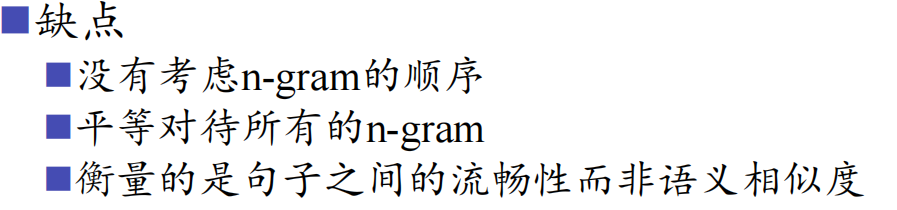
- BLUE评价指标确实有缺陷。我观察了val时评价指标高的生成句子并没有评价指标第的句子正确。
- 同时我们也实现了menteor评价指标
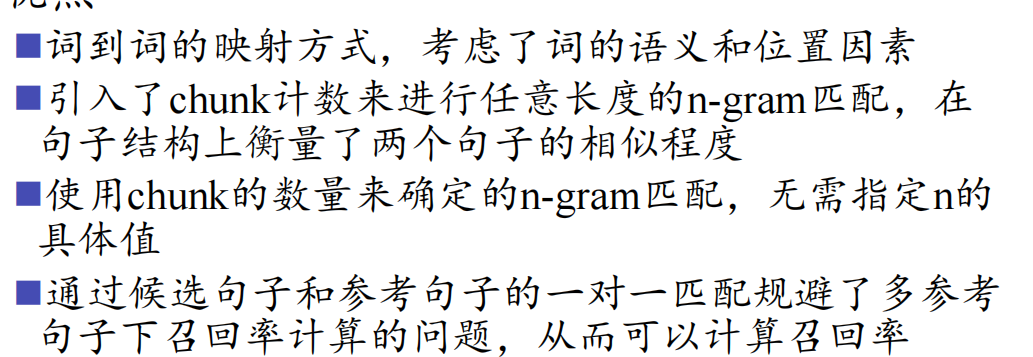
- ROUGE-L评价指标在test使用到了


In [23]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
def generated_str(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for idx in data:
        if idx in vocab_idx2word:
            result.append(vocab_idx2word[idx])
    
    return result
def generated_str2(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for inner_list in data:
        inner_result = []  # 存储内部列表的结果
        for idx in inner_list:
            if idx in vocab_idx2word:
                inner_result.append(vocab_idx2word[idx])
        result.append(inner_result)
    
    return result

def filter_useless_words(sent, filterd_words):
    # 去除句子中不参与BLEU值计算的符号
    return [w for w in sent if w not in filterd_words]

def evaluate(data_loader, model, config):
    model.eval()
    # 存储候选文本
    cands = []
    # 存储参考文本
    refs = []
    # 需要过滤的词
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image # 每张图片的标注数
    device = next(model.parameters()).device
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            # 通过束搜索，生成候选文本
            texts = model.generate_by_beamsearch(imgs.to(device), config.beam_k, config.max_len+2)
            print(texts)
            # 候选文本
            cands.extend([filter_useless_words(text, filterd_words) for text in texts])
            # 参考文本
            refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])

    # 实际上，每个候选文本对应cpi条参考文本
    multiple_refs = []
    for idx in range(len(refs)):
        multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
    # 计算BLEU-4值，corpus_bleu函数默认weights权重为(0.25,0.25,0.25,0.25)
    # 即计算1-gram到4-gram的BLEU几何平均值
    bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
    
    meteor_score_total = 0.0
    
    for idx in range(len(cands)):
        cand = generated_str(cands[idx])
        ref = generated_str2(multiple_refs[idx])
        meteor_score_total += meteor_score(ref,cand)

    meteor_avg = meteor_score_total / len(cands) if len(cands) > 0 else 0.0
    model.train()
    return bleu4,meteor_avg

## 七、训练模型

训练模型过程仍然是分为读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。

模型训练的具体方案为一共训练50轮，编码器和解码器的学习速率分别为0.00002和0.0001。

因为我们使用了预训练模型，因此编码器的学习率小一点，同时更小的学习率在后来的训练轮数可以更好地让模型微调，而不至于震荡

In [24]:
# 单卡训练
# 设置模型超参数和辅助变量
config = Namespace(
    max_len = 100,
    captions_per_image = 1,
    batch_size = 32,
    image_code_dim = 768,
    word_dim = 768,
    hidden_size = 512,
    num_layers = 6,
    encoder_learning_rate = 0.00002,
    decoder_learning_rate = 0.0001,
    num_epochs = 150,
    grad_clip = 4.0,
    alpha_weight = 1.0,
    evaluate_step = 3, # 每隔多少步在验证集上测试一次
    checkpoint = None, # 如果不为None，则利用该变量路径的模型继续训练
    best_checkpoint = '../model/Transformer/autovit_best_fashion_2.ckpt', # 验证集上表现最优的模型的路径
    last_checkpoint = '../model/Transformer/autovit_last_fashion_2.ckpt', # 训练完成时的模型的路径
    beam_k = 5
)

# 设置GPU信息
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") 

# 数据
data_dir = '../data/deepfashion/'
vocab_path = '../data/deepfashion/vocab.json'
train_loader, valid_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)

# 模型
with open(vocab_path, 'r') as f:
    vocab = json.load(f)

# 随机初始化 或 载入已训练的模型
start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = VitTransformerDecoder(image_code_dim=config.image_code_dim, vocab=vocab, word_dim=config.word_dim, num_layers=config.num_layers)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

# 优化器
optimizer = get_optimizer(model, config)

# 将模型拷贝至GPU，并开启训练模式
model.to(device)
model.train()

# 损失函数
loss_fn = UnsortedPackedCrossEntropyLoss()

best_res = 0
print("开始训练")
fw = open('logtrans2.txt', 'w')
all_step =  0
for epoch in range(start_epoch, config.num_epochs):
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        optimizer.zero_grad()
        # 1. 读取数据至GPU
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # 2. 前馈计算
        predictions, targets, lengths = model(imgs, caps, caplens)
        # 3. 计算损失
        # captions从第2个词开始为targets
        loss = loss_fn(predictions, targets, lengths)
        # 重随机注意力正则项，使得模型尽可能全面的利用到每个网格
        # 要求所有时刻在同一个网格上的注意力分数的平方和接近1
        
        loss.backward()
        # 梯度截断
        if config.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        
        # 4. 更新参数
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('epoch %d, step %d: loss=%.2f' % (epoch, i+1, loss.cpu()))
            fw.write('epoch %d, step %d: loss=%.2f \n' % (epoch, i+1, loss.cpu()))
            fw.flush()
            

        state = {
                'epoch': epoch,
                'step': i,
                'model': model,
                'optimizer': optimizer
                }
        if ((epoch+1) % config.evaluate_step == 0) and ((i+1)  == 100) :
            bleu_score,meteor_avg = evaluate(valid_loader, model, config)
            # 5. 选择模型
            if best_res < bleu_score:
                best_res = bleu_score
                torch.save(state, config.best_checkpoint)
            torch.save(state, config.last_checkpoint)
            fw.write('Validation@epoch, %d, step, %d, BLEU-4=%.2f,METEOR=%.4f\n' % 
                  (epoch, i+1, bleu_score,meteor_avg))
            fw.flush()
            print('Validation@epoch, %d, step, %d, BLEU-4=%.2f,METEOR=%.4f' % 
                  (epoch, i+1, bleu_score,meteor_avg))
checkpoint = torch.load(config.best_checkpoint)
model = checkpoint['model']
bleu_score,meteor_avg = evaluate(test_loader, model, config)
print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: %d, BLEU-4=%.2f' % 
      (checkpoint['epoch'], bleu_score))
fw.write('Epoch: %d, BLEU-4=%.2f' % 
      (checkpoint['epoch'], bleu_score))
fw.close()

开始训练
epoch 0, step 100: loss=3.72
epoch 0, step 200: loss=1.21
epoch 1, step 100: loss=0.72
epoch 1, step 200: loss=0.59
epoch 2, step 100: loss=0.54
[[112, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 46, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 8, 10, 17, 4, 61, 12, 13, 14, 1, 28, 3, 18, 29, 8, 9, 10, 11, 12, 13, 14, 1, 47, 26, 33, 34, 14, 113], [112, 1, 2, 3, 4, 76, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 19, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 22, 10, 17, 4, 61, 12, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 2, 3, 4, 42, 6, 7, 43, 9, 10, 11, 12, 13, 14, 1, 15, 16, 17, 18, 19, 14, 1, 20, 3, 18, 16, 60, 21, 14, 1, 9, 18, 22, 10, 17, 4, 61, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 39, 40, 50, 4, 6, 87, 88, 7, 8, 9, 10, 44, 13, 14, 1, 15, 16, 17, 18, 75, 14, 1, 74, 59, 47, 26, 18, 16, 60, 21, 14, 1, 74, 49, 29, 8, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113], [112, 1, 2, 3, 4, 6, 87, 88, 7, 8, 9, 10, 61,

KeyboardInterrupt: 

预训练vit

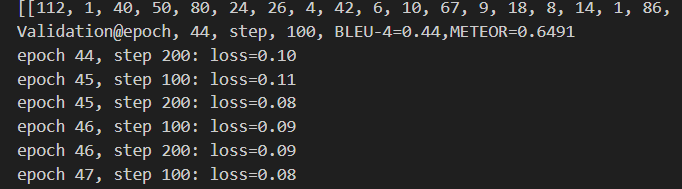

自己搭建vit 

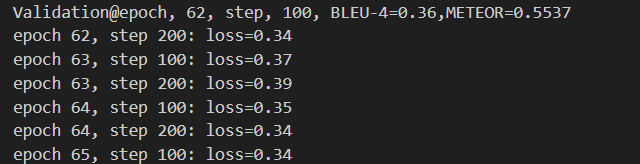

但是并不认为自己搭建的vit更差：
- 学习率不同，预训练vit更小，因此在训练后期还可以稳步下降，但是自己搭建的vit再后来没法下降了，在震荡。
- 纬度不同，自己的vit是dim是512维，与训练是768，然后编码器的层数不同，自己的vit少了一半。

### 7.1 对比训练过程学习到的数据不同
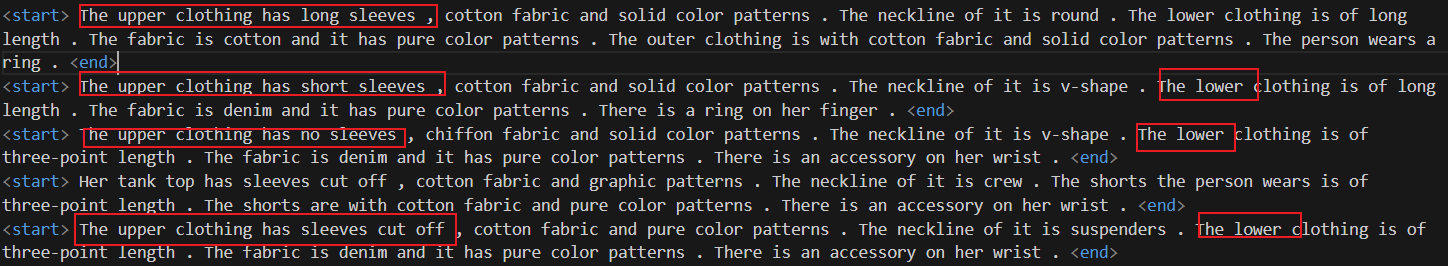

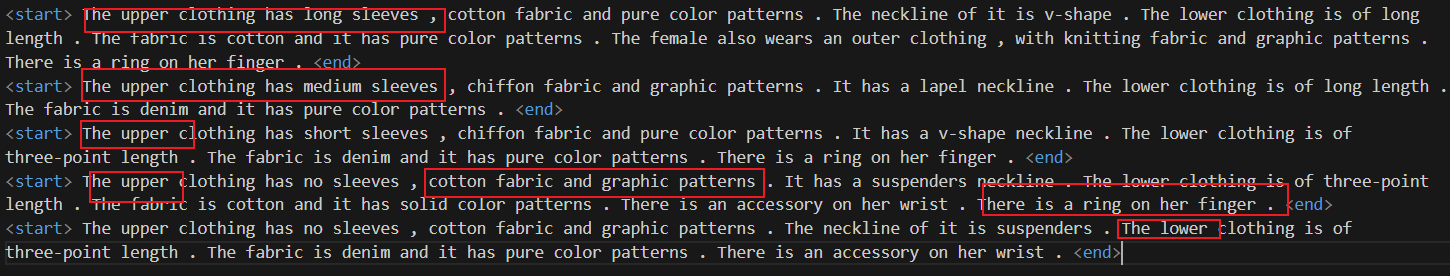
**以上是blue<0.3的**
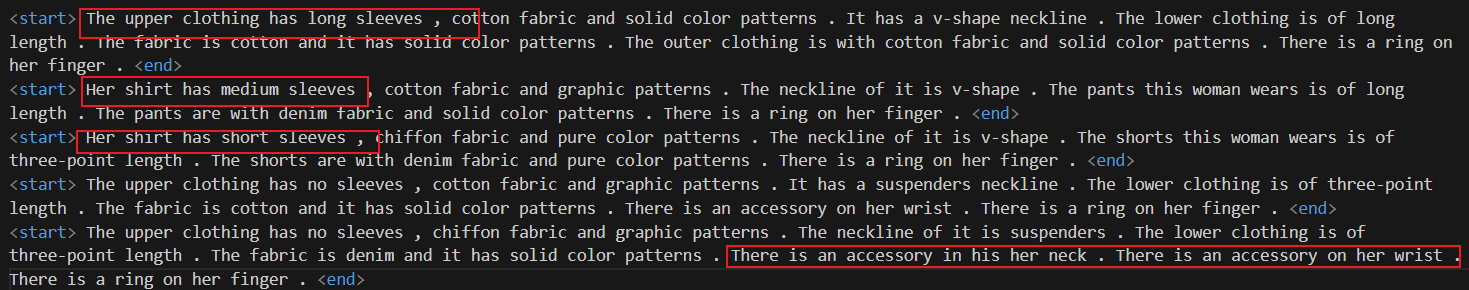
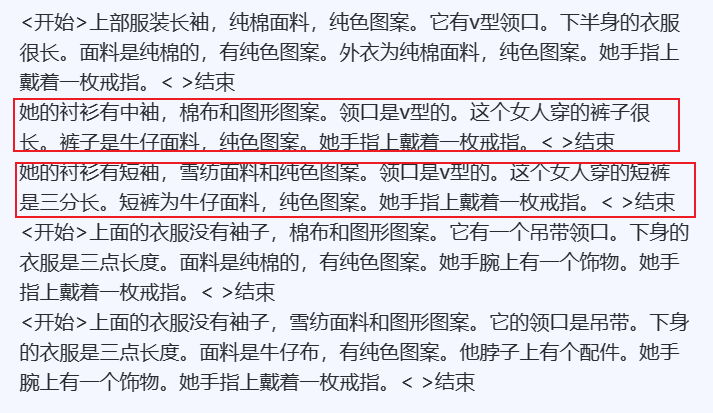

对比可以发现语法结构更加丰富，最开始只关注整体结构，后来开始关注性别的表达。

**最后是0.44BLUE值**
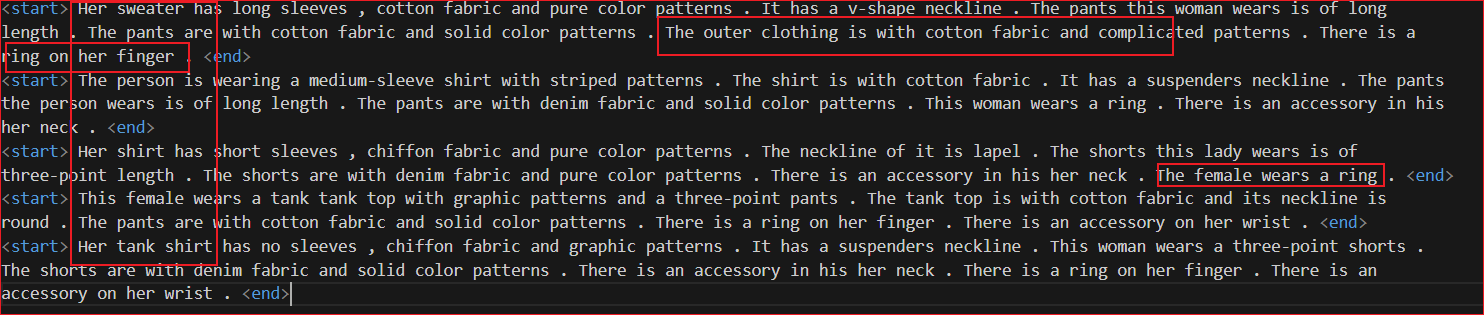
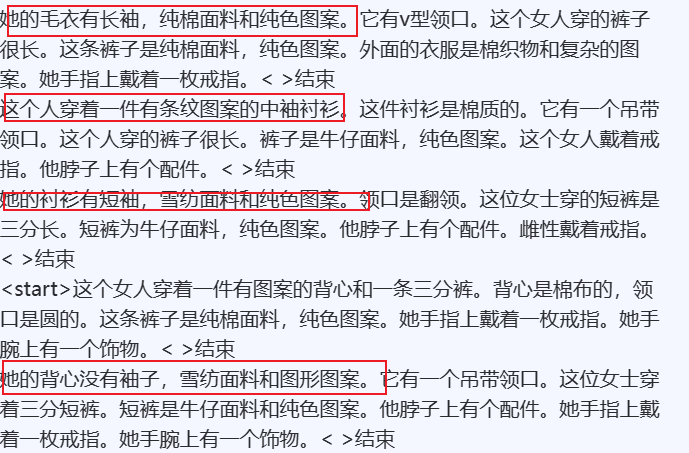

## 八、模型测试
测试预训练Vit、手搭Vit、CNN编码器+Transformer解码器

In [18]:
train_loader, valid_loader, test_loader   = mktrainval('../data/deepfashion', '../data/deepfashion/vocab.json', 32, 4)

In [23]:
# ROUGE-L 评估
from rouge import Rouge
import numpy as np
from collections import defaultdict
from nltk.util import ngrams
import math
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

config = Namespace(
    max_len = 100,
    captions_per_image = 1,
    batch_size = 32,
    image_code_dim = 768,
    word_dim = 768,
    hidden_size = 512,
    num_layers = 6,
    encoder_learning_rate = 0.00002,
    decoder_learning_rate = 0.0001,
    num_epochs = 150,
    grad_clip = 4.0,
    alpha_weight = 1.0,
    evaluate_step = 3, # 每隔多少步在验证集上测试一次
    checkpoint = None, # 如果不为None，则利用该变量路径的模型继续训练
    best_checkpoint = '../model/Transformer/autovit_best_fashion_2.ckpt', # 验证集上表现最优的模型的路径
    last_checkpoint = '../model/Transformer/autovit_last_fashion_2.ckpt', # 训练完成时的模型的路径
    beam_k = 5
)
def load_vocab(vocab_path):
    with open(vocab_path, 'r') as f:
        vocab_word = json.load(f)
    vocab_idx2word = {idx:word for word,idx in vocab_word.items()}
    return vocab_idx2word

def filter_useless_words(sent, filter_words):
    return [w for w in sent if w not in filter_words]

def rouge_l_score(candidate, reference, vocab_word):

    # 将索引列表转换为文本
    candidate_text = ' '.join([vocab_word[idx] for idx in candidate])
    reference_text = ' '.join([vocab_word[idx] for idx in reference])
    
    # 如果参考文本为空，返回一个较小的 ROUGE-L 分数
    if not reference_text.strip():
        return 0.0
    
    # 初始化ROUGE评估器
    rouge = Rouge()

    # 计算ROUGE-L分数
    scores = rouge.get_scores(candidate_text, reference_text)
    rouge_l = scores[0]['rouge-l']['f']

    # print("rouge_l:", rouge_l)
    return rouge_l

def compute_cider_d(refs, cands, n=4, sigma=6.0):
    # 计算 DF 表示每个 n-gram 在参考文本中出现的频率
    def compute_df(refs, n):
        df = defaultdict(int)
        for ref in refs:
            for ngram in set(ngrams(ref, n)):
                df[ngram] += 1
        return df

    # 计算候选文本的加权 n-gram 得分
    def compute_weighted_ngram_score(refs, cands, df, n, sigma):
        scores = []
        for cand in cands:
            # print(cand)
            cand_ngrams = list(ngrams(cand, n))
            # print(cand_ngrams)
            cand_len = len(cand_ngrams)
            if cand_len == 0:
                continue
            score = 0.0
            for ngram in cand_ngrams:
                score += np.log((df[ngram] + 1) / (df[ngram[:n-1]] + 1))
            score /= cand_len
            score = np.exp(min(0, 1 - (cand_len / sigma))) * score
            scores.append(score)
        return scores

    cider_d = 0
    for i in range(1,n+1):
        # 将参考文本和候选文本转换为 n-gram 形式
        refs_ngrams = [list(ngrams(ref, i)) for ref in refs]
        cands_ngrams = [list(ngrams(cand, i)) for cand in cands]
        
        # 计算 DF 表示每个 n-gram 在参考文本中出现的频率
        df = compute_df(refs_ngrams, i)

        # 计算候选文本的加权 n-gram 得分
        scores = compute_weighted_ngram_score(refs_ngrams, cands_ngrams, df, i, sigma)
        score = np.mean(scores)
        if math.isnan(score):
            score = 0
        # print(score)
        cider_d+=0.25*score

    return cider_d

def generated_str(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for idx in data:
        if idx in vocab_idx2word:
            result.append(vocab_idx2word[idx])
    
    return result
def generated_str2(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for inner_list in data:
        inner_result = []  # 存储内部列表的结果
        for idx in inner_list:
            if idx in vocab_idx2word:
                inner_result.append(vocab_idx2word[idx])
        result.append(inner_result)
    
    return result

def evaluate_rouge_l(data_loader, model, config):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image
    device = next(model.parameters()).device

    vocab_path = "../data/deepfashion/vocab.json"
    vocab_word = load_vocab(vocab_path)
    
    # print("开始处理数据:")
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            texts = model.generate_by_beamsearch(imgs.to(device), config.beam_k, config.max_len+2)
            cands.extend([filter_useless_words(text, filterd_words) for text in texts])
            refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])
    
    # 按照需要，将参考文本拆分为多个列表，每个候选文本对应 cpi 条参考文本
    multiple_refs = []
    for idx in range(len(refs)):
        multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
        
    # print("数据处理完成")
    # 计算BLEU-4值，corpus_bleu函数默认weights权重为(0.25,0.25,0.25,0.25)
    # 即计算1-gram到4-gram的BLEU几何平均值
    bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
    # 计算 METEOR 值
    meteor_score_total = 0.0
    
    for idx in range(len(cands)):
        cand = generated_str(cands[idx])
        ref = generated_str2(multiple_refs[idx])
        meteor_score_total += meteor_score(ref,cand)

    meteor_avg = meteor_score_total / len(cands) if len(cands) > 0 else 0.0
    # 计算 CIDEr-D 值
    # cider_d = compute_cider_d(refs, cands)
    # 计算 ROUGE-L 值
    rouge_l_scores = [rouge_l_score(cand, ref, vocab_word) for cand, ref_list in zip(cands, multiple_refs) for ref in ref_list]
    
    # 取 ROUGE-L 分数的平均值
    rouge_l_avg = sum(rouge_l_scores) / len(rouge_l_scores) if rouge_l_scores else 0.0
    
    model.train()
    return bleu4, meteor_avg, rouge_l_avg



测试预训练Vit+Transformer

In [24]:
checkpoint1 = torch.load('../model/Transformer/autovit_best_fashion_2.ckpt')
model1 = checkpoint1['model']
BLUE, METEOR, ROUGE = evaluate_rouge_l(test_loader, model1, config)
print(f'预训练Vit模型+Transformer的BLEU-4值为{BLUE},METEOR值为{METEOR},ROUGE-L值为{ROUGE}')

预训练Vit模型+Transformer的BLEU-4值为0.4202120669139459,METEOR值为0.636005446393113,ROUGE-L值为0.6861283585441018


测试手搭Vit+Transformer

先重新搭建一下模型

In [30]:
class VitTransformerDecoder(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, num_layers):
        super(VitTransformerDecoder, self).__init__()
        self.vocab = vocab
        # self.encoder = VitEncoder()
        # self.encoder = ImageEncoder()
        self.encoder = ViT(
            image_size = 224,
            patch_size = 16,
            num_classes = 1000,
            dim = word_dim,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.2,
            emb_dropout = 0.2
        )
        self.decoder = TransformerDecoder(
            vocab_size=len(vocab),
            word_dim=word_dim,
            num_layers=num_layers,
            num_heads=4,
            mlp_dim=2048,
            dropout = 0.2,
        )

    def forward(self, image, captions, lengths):
        """
        image: (batch_size, 3, 224, 224)
        captions: (batch_size, num_steps) 图片标注
        lengths: (batch_size, ) 图片标注的长度
        """
        image_features = self.encoder(image)
        predictions, targets, lengths = self.decoder(image_features, captions, lengths)
        return predictions, targets, lengths
    
    def generate_by_beamsearch(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)  # 图片特征
        # print(f'image_codes{image_codes.shape}')  #([2, 512, 1024])
        texts = []
        device = images.device
        # 对每个图像样本执行束搜索
        for image_code in image_codes:  # 对于每张图片
            # 将图像表示复制k份
            image_code = image_code.unsqueeze(0).repeat(beam_k,1,1,1)
            # 生成k个候选句子，初始时，仅包含开始符号<start>
            cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device)  # 初始状态
            # print(f'cur_sents{cur_sents.shape}')
            cur_sent_embed = self.decoder.embed(cur_sents)  # embed编码
            sent_lens = torch.LongTensor([1]*beam_k).to(device)  # 当前长度只有1
            # 存储已生成完整的句子（以句子结束符<end>结尾的句子）
            end_sents = []
            # 存储已生成完整的句子的概率
            end_probs = []
            # 存储未完整生成的句子的概率
            probs = torch.zeros(beam_k, 1).to(device)
            k = beam_k
            step= 1
            while True:
                image_code = image_code.squeeze(1)
                # print(f'image_codes[k]{image_code[:k].shape}')
                # print(f'cur_sent_embed{cur_sent_embed.shape}')
                preds = self.decoder.forward_step(image_code[:k], cur_sent_embed,0,step=step)  # image_features, captions, lengths, i+1
                # print(f'print{preds.shape}') # 只预测一个词[5, 123]
                step+=1
                # -> (k, vocab_size)
                preds = nn.functional.log_softmax(preds, dim=1)  # 转化成概率分布
                
                # 对每个候选句子采样概率值最大的前k个单词生成k个新的候选句子，并计算概率
                # -> (k, vocab_size)
                probs = probs.repeat(1,preds.size(1)) + preds
                # print(f'prob{probs.shape}')
                non_end_indices = [i for i in range(len(self.vocab)) if i != self.vocab['<end>']]
                if cur_sents.size(1) == 1:  # 这一步容易出end
                    # 第一步时，所有句子都只包含开始标识符，因此，仅利用其中一个句子计算topk
                    values, indices = probs[0][non_end_indices].topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices}')
                else:
                    # probs: (k, vocab_size) 是二维张量
                    # topk函数直接应用于二维张量会按照指定维度取最大值，这里需要在全局取最大值
                    # 因此，将probs转换为一维张量，再使用topk函数获取最大的k个值
                    values, indices = probs.view(-1).topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices.shape}')
                # 计算最大的k个值对应的句子索引和词索引
                sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc') 
                # print(f'sent_indices{sent_indices.shape}')
                word_indices = indices % vocab_size 
                # 将词拼接在前一轮的句子后，获得此轮的句子
                # print(f'原来cur_sent{cur_sents.shape}')
                cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)
                # print(f'后来cur_sent{cur_sents.shape}')
                # 查找此轮生成句子结束符<end>的句子
                end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
                if len(end_indices) > 0:
                    end_probs.extend(values[end_indices])
                    end_sents.extend(cur_sents[end_indices].tolist())
                    # 如果所有的句子都包含结束符，则停止生成
                    k -= len(end_indices)
                    if k == 0:
                        break
                # 查找还需要继续生成词的句子
                cur_indices = [idx for idx, word in enumerate(word_indices) 
                               if word != self.vocab['<end>']]
                if len(cur_indices) > 0:
                    cur_sent_indices = sent_indices[cur_indices]
                    cur_word_indices = word_indices[cur_indices]
                    # 仅保留还需要继续生成的句子、句子概率、隐状态、词嵌入
                    cur_sents = cur_sents[cur_indices]
                    probs = values[cur_indices].view(-1,1)
                    cur_sent_embed = self.decoder.embed(
                        cur_sents)
                # 句子太长，停止生成
                if cur_sents.size(1) >= max_len:
                    break
            if len(end_sents) == 0:
                # 如果没有包含结束符的句子，则选取第一个句子作为生成句子
                gen_sent = cur_sents[0].tolist()
            else: 
                # 否则选取包含结束符的句子中概率最大的句子
                gen_sent = end_sents[end_probs.index(max(end_probs))]
                # gen_sent = random.choice(end_sents)
                # print(f'endstate{end_sents}')
                # print(f'gen_sent{gen_sent}')
            texts.append(gen_sent)
        return texts

In [31]:
checkpoint2 = torch.load('../model/Transformer/autovit_best_fashion_1.ckpt')
model2 = checkpoint2['model']
BLUE, METEOR, ROUGE = evaluate_rouge_l(test_loader, model2, config)
print(f'预训练Vit模型+Transformer的BLEU-4值为{BLUE},METEOR值为{METEOR},ROUGE-L值为{ROUGE}')

预训练Vit模型+Transformer的BLEU-4值为0.3653944029488331,METEOR值为0.5490004346221652,ROUGE-L值为0.6123323760417846


#### 结果对比
| 模型 | BLUE  |	METEOR | ROUGE-L |
|:--------| :---------:|--------:|--------:|
| 预训练vit+Transformer | 0.4202 |0.6360|0.6360|
| 手搭vit+Transformer | 0.3653 |0.5490|0.6123|

{'The': 1, 'upper': 2, 'clothing': 3, 'has': 4, 'long': 5, 'sleeves': 6, ',': 7, 'cotton': 8, 'fabric': 9, 'and': 10, 'solid': 11, 'color': 12, 'patterns': 13, '.': 14, 'neckline': 15, 'of': 16, 'it': 17, 'is': 18, 'v-shape': 19, 'lower': 20, 'length': 21, 'denim': 22, 'This': 23, 'lady': 24, 'also': 25, 'wears': 26, 'an': 27, 'outer': 28, 'with': 29, 'complicated': 30, 'female': 31, 'wearing': 32, 'a': 33, 'ring': 34, 'on': 35, 'her': 36, 'finger': 37, 'neckwear': 38, 'Her': 39, 'tank': 40, 'shirt': 41, 'no': 42, 'chiffon': 43, 'graphic': 44, 'It': 45, 'round': 46, 'person': 47, 'pants': 48, 'are': 49, 'top': 50, 'woman': 51, 'trousers': 52, 'There': 53, 'belt': 54, 'accessory': 55, 'wrist': 56, 'sweater': 57, 'lattice': 58, 'the': 59, 'three-point': 60, 'pure': 61, 'in': 62, 'his': 63, 'neck': 64, 'long-sleeve': 65, 'plaid': 66, 'its': 67, 'lapel': 68, 'socks': 69, 'shoes': 70, 'suspenders': 71, 'short-sleeve': 72, 'T-shirt': 73, 'shorts': 74, 'crew': 75, 'short': 76, 'sleeveless': 7

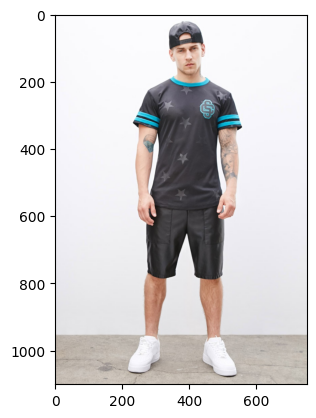

In [29]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
    print(vocab)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open('../data/deepfashion/test_data.json', 'r') as f:
    data = json.load(f)

# 读取图片
image_num = 10
content_img = Image.open(data['IMAGES'][image_num])
plt.imshow(content_img)
print("真实caption:")
print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][image_num]]))
val_tx = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

content_img = val_tx(content_img).unsqueeze(0)  # 添加 batch 维度
model1.to('cuda:1')
content_img = content_img.to('cuda:1')  # 将输入张量移动到 GPU 上
model1.eval()
predictions = model1.generate_by_beamsearch(content_img,5,100)
generated_sentences(predictions)

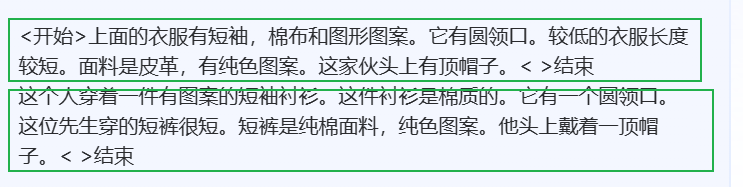